# Adult Census Income Prediction

- Dataset Source : https://archive.ics.uci.edu/ml/datasets/Adult

### The Prediction task is to determine whether a person makes over 50K a year.


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [49]:
column_names= ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", 
               "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]

In [50]:
data = pd.read_csv('adult.data', names=column_names, sep=', ',engine='python')

## Exploratory Data Analysis

- Overview of the existing data

In [51]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


- If we observe carefully, the values in feature `education-num` is just a number encoding of the fueature `education` and is redundant.
- We can drop the redundant column and preceed with the analysis.

In [52]:
data.drop(['education-num'],axis=1,inplace=True)

### Continuos Variables overview

In [22]:
data.describe()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


###  Categorical Variables Overview 

In [23]:
data.describe(include='O')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [24]:
# Total number of unique categories in the data, excluding the target value "salary"
data.describe(include='O').drop('salary',axis=1).loc['unique'].sum()

102

- From the above overview of data, we have `5 continuous features` and `8 categorical features` in our data.
- Among the 8 categorical featues, we have `102 unique categories` which will become a total of `108 categories`, since I am going to use one-hot-encoding to build the feature set.

# Data Cleaning

In [25]:
#Checking for duplicate values in data
data.duplicated().sum()

24

In [26]:
# Example showing the duplicate rows in data
data[data.duplicated(keep=False)].sort_values(by=['age','fnlwgt']).head(6)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
17673,19,Private,97261,HS-grad,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
18698,19,Private,97261,HS-grad,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
6990,19,Private,138153,Some-college,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
21318,19,Private,138153,Some-college,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
15189,19,Private,146679,Some-college,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
21490,19,Private,146679,Some-college,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K


In [29]:
# Our data consists of some duplicated rows, so we keep 1 row among the duplicated subset
data.drop_duplicates(keep='first',inplace=True)

In [30]:
# Checking for missing values,
data.replace('?',np.nan,inplace=True)
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
salary               0
dtype: int64

- All the missing values are present in categorical variables, so we use mode to impute them

In [31]:
missing_cols = ['workclass','occupation','native-country']
for col in missing_cols:
    data[col].fillna(data[col].mode().iloc[0], inplace=True)

In [32]:
#Checking for null values after imputation
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [33]:
def remove_inconsistent_relationship(row):
    if ((row['sex'] == 'Male') & (row['relationship'] == 'Wife')):
        return 'Husband'
    elif((row['sex'] == 'Female') & (row['relationship'] == 'Husband')):
        return 'Wife'
    else: return row.relationship

In [34]:
data.relationship = data.apply(lambda x: remove_inconsistent_relationship(x),axis=1)

## Visualizing the features

- Understanding the data distribution through visualizations

#### Continuous Variables

In [35]:
cont_vars = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']

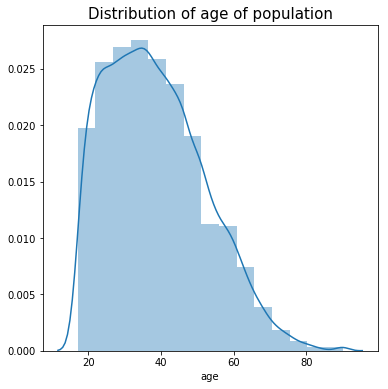

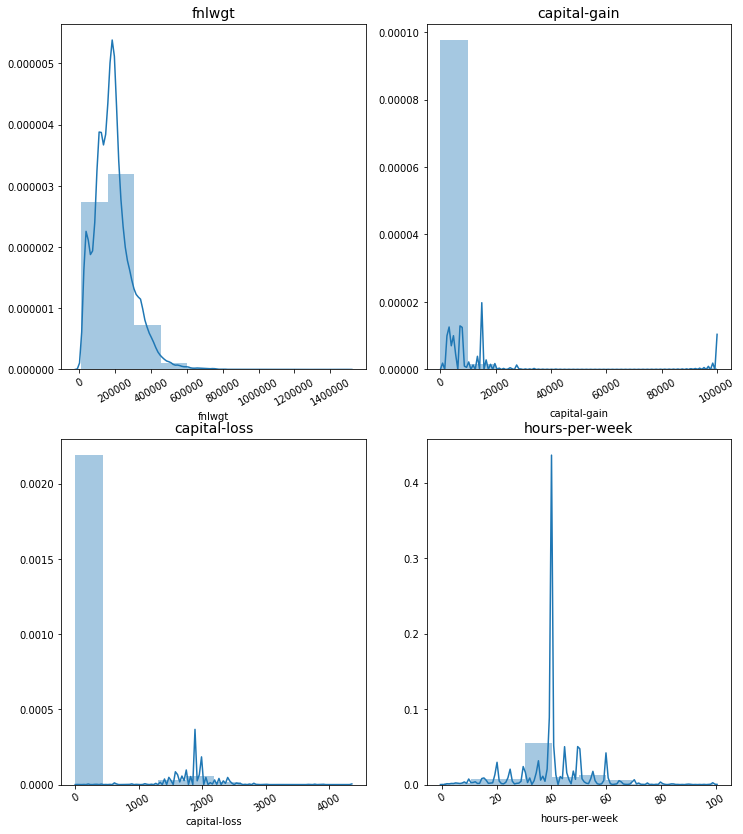

In [36]:
fig, axis = plt.subplots(figsize=(6,6))
sns.distplot(data['age'],bins=15, ax=axis)
axis.set_title('Distribution of age of population', fontsize=15)
plt.show()

fig,axes = plt.subplots(figsize=(12,14),nrows=2,ncols=2)
axes=axes.flatten()
for i,col in enumerate(cont_vars[1:]):
    sns.distplot(data[col],bins=10,ax=axes[i])
    axes[i].set_title(col,fontsize=14)
    for tick in axes[i].get_xticklabels(): tick.set_rotation(30)
plt.show()

#### Categorical Variables

In [37]:
categorical_vars = ["workclass","education", "marital-status", "occupation", 
               "relationship", "race", "sex", "native-country"]

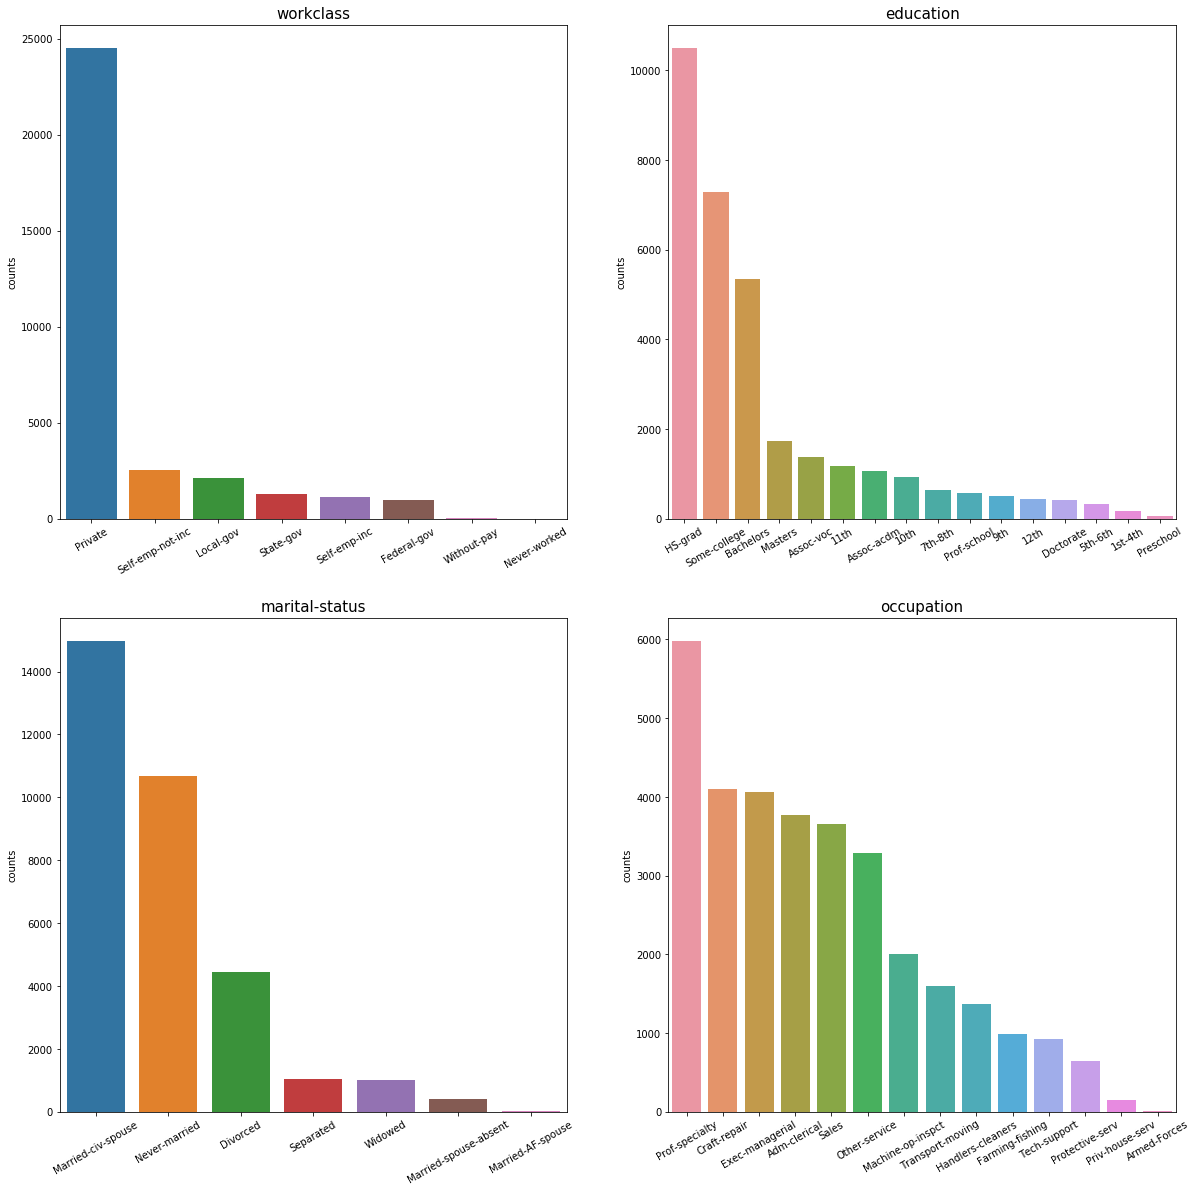

In [38]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)
axes = axes.flatten()
for i, col in enumerate(categorical_vars[:4]):
    value_counts=data[col].value_counts()
    value_counts=value_counts.sort_values(ascending=False)
    sns.barplot(x=value_counts.index.values, y=value_counts.values,ax=axes[i])
    for tick in axes[i].get_xticklabels(): tick.set_rotation(30)
    axes[i].set_title(col,fontsize=15)
    axes[i].set_ylabel('counts')
plt.show()


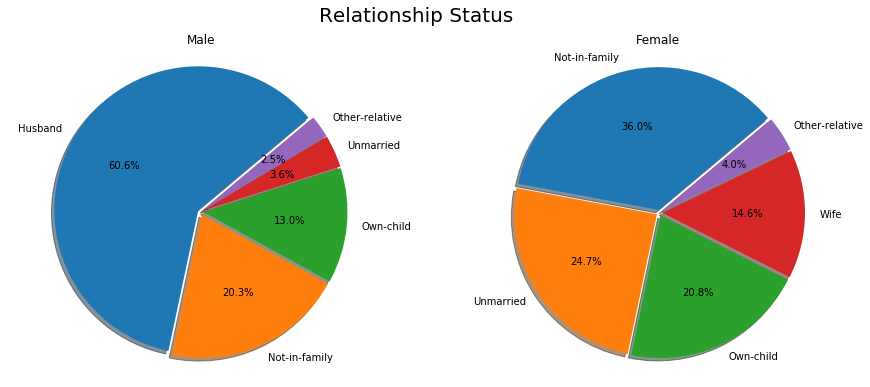

In [39]:
# Relationship status
fig, axes = plt.subplots(figsize=(15,6),ncols=2)
axes = axes.flatten()
for i,gndr in enumerate(data.sex.unique()):
    data_ = data[data.sex == gndr]
    chart_values = data_['relationship'].value_counts()
    labels = chart_values.index.values 
    sizes = chart_values.values
    explode = [0.02]*labels.shape[0]

    axes[i].pie(sizes, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=40)
    axes[i].axis('equal')
    axes[i].set_title(gndr)
fig.suptitle('Relationship Status',fontsize=20)
plt.show()

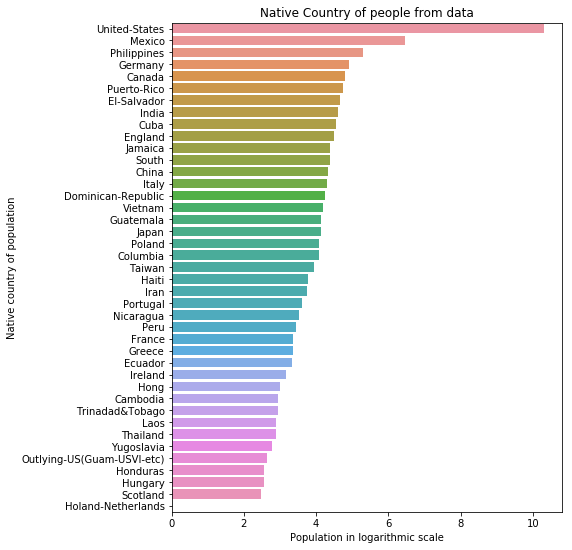

In [40]:
#Native-Country
plt.figure(figsize=(7,9))
value_counts = data['native-country'].value_counts().apply(np.log)
valuee_counts = value_counts.sort_values()
sns.barplot(x=value_counts.values, y=value_counts.index.values)
plt.xlabel('Population in logarithmic scale')
plt.ylabel('Native country of population')
plt.title('Native Country of people from data')
plt.show()

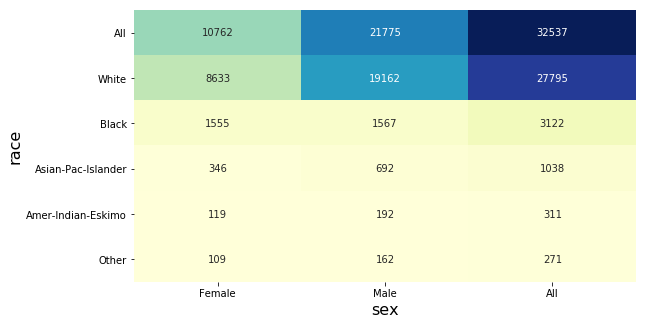

In [41]:
# Race, Gender
fig,ax=plt.subplots(figsize=(9,5))
sns.heatmap(pd.crosstab(data.race,data.sex, margins=True).sort_values(by='Male',ascending=False),
           cmap="YlGnBu", annot=True, fmt='d', ax=ax, cbar=False)
ax.set_ylabel('race',fontsize=16)
ax.set_xlabel('sex', fontsize=16)
plt.show()

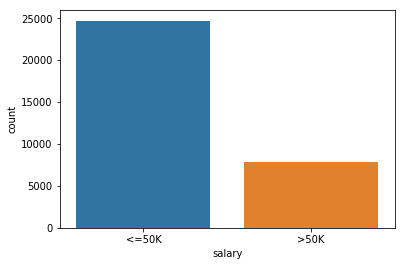

In [42]:
#Salary
ax = sns.countplot(data.salary)
plt.show()

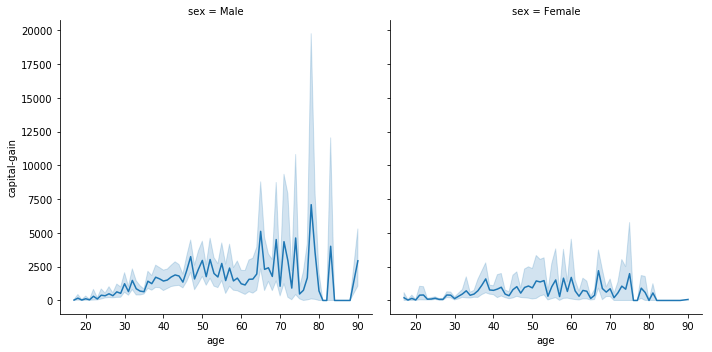

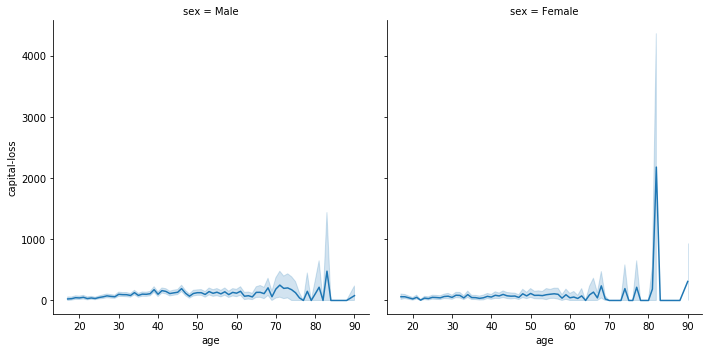

In [43]:
sns.relplot(x="age", y="capital-gain", kind="line", data=data, col='sex')
sns.relplot(x="age", y="capital-loss", kind="line", data=data, col='sex')

## Modelling

In [27]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings

In [28]:
warnings.filterwarnings('ignore')

In [29]:
data_encoded = pd.get_dummies(data,columns=['workclass','sex', 'marital-status', 'education',
                                    'race','relationship','occupation','native-country'], drop_first=True)

In [30]:
X = data_encoded.drop(['salary'],axis=1)
y = data_encoded.salary.apply(lambda x: 1 if x == '>50K' else 0)

In [31]:
sc = StandardScaler()
X = sc.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X,y,
                                    random_state=52, 
                                    test_size=0.2,
                                    stratify=y, shuffle=True)

### LogisticRegression

In [41]:
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] , 
              'penalty':['l1','l2'],
              'class_weight': [None, 'balanced']}

In [42]:
lr_clf = GridSearchCV(LogisticRegression(random_state=52), lr_param_grid, cv=10, n_jobs=-1)

In [43]:
%%time
lr_clf.fit(x_train, y_train)

CPU times: user 4.7 s, sys: 1.45 s, total: 6.14 s
Wall time: 1min 46s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=52, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
lr_best = lr_clf.best_estimator_

In [45]:
lr_clf.best_params_

{'C': 1, 'class_weight': None, 'penalty': 'l2'}

## Decision Tree

In [46]:
dt_param_grid = {'criterion': ['gini','entropy'] , 
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12],
              'class_weight': [None, 'balanced']}

In [47]:
dt_clf = GridSearchCV(DecisionTreeClassifier(random_state=52), dt_param_grid, cv=10, n_jobs=4)

In [48]:
%%time
dt_clf.fit(x_train, y_train)

CPU times: user 1.78 s, sys: 277 ms, total: 2.06 s
Wall time: 24.5 s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=52,
                                              splitter='best'),
             iid='warn', n_jobs=4,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                    

In [49]:
dt_best = dt_clf.best_estimator_

In [50]:
dt_clf.best_params_

{'class_weight': None, 'criterion': 'gini', 'max_depth': 9}

## Random Forest

In [51]:
rf_param_grid = {'n_estimators':[50,100,150,200,300,400],
                'max_depth':[10,20,30,40,50],
                'class_weight':[None, 'balanced']}

In [52]:
rf_clf = GridSearchCV(RandomForestClassifier(random_state=52), rf_param_grid, cv=5, n_jobs=-1)

In [53]:
%%time
rf_clf.fit(x_train,y_train)

CPU times: user 3.84 s, sys: 1.4 s, total: 5.24 s
Wall time: 1min 45s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=52,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cl

In [54]:
rf_best = rf_clf.best_estimator_

In [55]:
rf_clf.best_params_

{'class_weight': None, 'max_depth': 20, 'n_estimators': 50}

## Xgboost

In [32]:
xgb_param_grid = {'n_estimators':[50,100,200,300,400],
                'max_depth':[3,4,5,6,7,8]}

In [37]:
xgb_clf = GridSearchCV(XGBClassifier(random_state=52), xgb_param_grid, cv=5, n_jobs=8)

In [38]:
%%time
xgb_clf.fit(x_train,y_train)

CPU times: user 22.3 s, sys: 459 ms, total: 22.8 s
Wall time: 5min 35s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=52, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=8,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit

In [39]:
xgb_best = xgb_clf.best_estimator_

In [40]:
xgb_clf.best_params_

{'max_depth': 5, 'n_estimators': 300}

### Evaluating the Best Classifiers

In [73]:
best_classifiers = [lr_best, dt_best, rf_best, xgb_best]
clf_name = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
acc = []
for i,clf in enumerate(best_classifiers):
    y_pred = clf.predict(x_test)
    acc.append(accuracy_score(y_test,y_pred))

In [81]:
results = pd.DataFrame([clf_name,acc]).T

In [82]:
results.columns = ['Classifier', 'Accuracy']

In [85]:
results.Accuracy = results.Accuracy.apply(lambda x: x*100)

In [86]:
results

,Classifier,Accuracy
0,Logistic Regression,84.880148
1,Decision Tree,85.248924
2,Random Forest,85.878918
3,XGBoost,87.169637


- From the above results, the best classifier that we have obtained is `XGBoost` with Accuracy of `87.17`

### Feature Importances of the calssifier

In [125]:
feature_weights = xgb_best.feature_importances_
feature_names = data_encoded.drop(['salary'],axis=1).columns
feature_imp = pd.DataFrame([feature_names, feature_weights]).T
feature_imp.columns = ['Feature Name', 'Weight']

feature_imp = feature_imp.sort_values(by='Weight',ascending=False)

In [126]:
top_features = feature_imp.head(30)

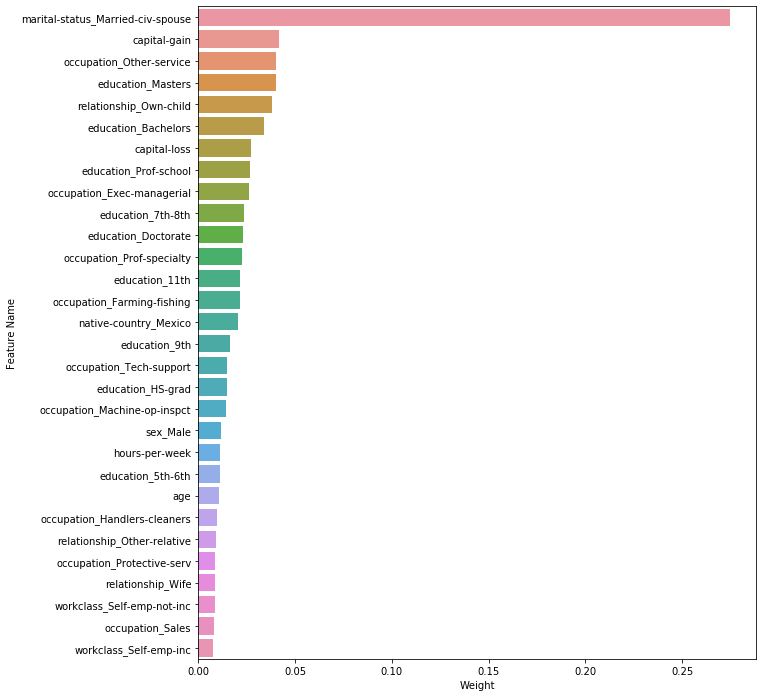

In [129]:
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=top_features.Weight, y=top_features['Feature Name'], ax=ax)

- From the above observation, we can understand that people who are married to `civ-spouse`, have more `capital gain`, with a `Masters degree` or a `Bachelors degree` will earn over 50K dollars.